Exploration into how an increase in buy in can effect the EV of past placements. The buy-in increase will be an increase of $35 to $50. 

* Scenario 1: Increase Buy In, Distribute to 1st, 2nd 3rd. 
* Scenario 2: Increase Buy In, Weekly $10 winners
* Scenario 3: Increase Buy In, Winner of consolation bracket gets money back

|       | Scenario 1 | Scenario 2 | Scenario 3 |
|-------|------------|------------|------------|
| 1st   | $321.43    | $246.43    | $294.64    |
| 2nd   | $214.29    | $164.29    | $196.43    |
| 3rd   | $64.29     | $49.29     | $58.93     |
| Bonus | $0.00      | $140.00    | $50.00     |
| Total | $600.00    | $600.00    | $600.00    |

Data is using last 4 seasons, details to note:
* ESPN_1 is not included (sorry Nicole)
* Sleeper_1 and Sleeper_2 are 10 team seasons where the total was $350, or $500 in the sim. 14 week reg season
* Sleeper_3 and Sleerer_4 are 12 team seasons where the total was $420, or $600 in the sim. 14 week reg season



In [3]:
from tools.sql_cnx import sql_cnx
import pandas as pd

# query function to access planetscale db
def query(query_txt):
    instance = sql_cnx('init/.env')
    conn = instance.cnx
    result = pd.read_sql(sql = query_txt,con = conn)
    instance.cleanup()
    return result

In [11]:
users = query('''
select distinct user_id, username from test.users
''')
users.head()

,user_id,username
0,465633370747957248,LEDRs
1,465636493809938432,smlederer
2,466716381887328256,bbrbr
3,469271575548391424,zgreen1017
4,469319841732358144,aleith


### Baseline current

In [77]:
# lazy method to get past results from csv vs. Sleeper API as that has not been added to the planetscale DB yet. 
# 4 in this context is the winner of the consolation bracker, not the loser of the 3/4 placement.

past_results = pd.read_csv('files/Past_Placement.csv').dropna()
past_results['user_id'] = [int(x) for x in past_results['user_id']]
past_results = past_results[(past_results['payout']>0) & (past_results['year']>=2019)]

user_winners = past_results[['user_id','payout']].groupby('user_id').sum('payout').reset_index()


buyins_by_user = query('''
select user_id, count(distinct league_id) as seasons, 35*count(distinct league_id) as total_buy_in
from test.users
group by 1
''')

buyins_by_user['user_id'] = [int(x) for x in buyins_by_user['user_id']]

profit_table =buyins_by_user.merge(user_winners,on='user_id',how='left').fillna(0)
profit_table['profit'] = profit_table['payout']-profit_table['total_buy_in']
profit_table.sort_values('profit')

,user_id,seasons,total_buy_in,payout,profit
0,465633370747957248,4,140,0.0,-140.0
3,469271575548391424,4,140,0.0,-140.0
8,472159133173280768,4,140,0.0,-140.0
9,472234548525002752,4,140,0.0,-140.0
5,469921663765442560,4,140,45.0,-95.0
12,866029249553944576,1,35,0.0,-35.0
7,471806540358086656,3,105,115.0,10.0
6,471147635869216768,4,140,200.0,60.0
2,466716381887328256,4,140,220.0,80.0
10,728408081750405120,2,70,150.0,80.0


### Scenario 1:
Distribute to 1st, 2nd, 3rd

In [126]:
#initialize scenario 1 buy ins

s1_buyin = buyins_by_user[['user_id','seasons']]
s1_buyin['spend'] = 50*s1_buyin['seasons']
new_dist = pd.read_csv('files/new_dist.csv')
s1_dist = new_dist[['Placement','scenario_1']]
s1_dist = s1_dist.iloc[0:3]
s1_dist['Placement'] = [int(i) for i in s1_dist['Placement']]
s1_dist

#calc winnings by the new dist

s1_table = past_results[['user_id','placement']].merge(s1_dist,left_on= 'placement', right_on = 'Placement')
s1_table.columns = ['user_id','placement','placement_','payout']
s1_table['payout']

s1_results = s1_table[['user_id','payout']].groupby('user_id').sum('payout').reset_index()

#calcuate the new final profits

s1_profit_table =s1_buyin.merge(s1_results,on='user_id',how='left').fillna(0)
s1_profit_table['profit'] = s1_profit_table['payout']-s1_profit_table['spend']
s1_profit_table[['user_id','profit']].sort_values('profit')

,user_id,profit
0,465633370747957248,-200.00
3,469271575548391424,-200.00
8,472159133173280768,-200.00
9,472234548525002752,-200.00
5,469921663765442560,-135.71
12,866029249553944576,-50.00
7,471806540358086656,64.29
10,728408081750405120,114.29
6,471147635869216768,121.43
2,466716381887328256,142.87


### Scenario 2:

$10 to highest score each week

In [125]:
#initialize scenario 3 buyins

s2_buyin = buyins_by_user[['user_id','seasons']]
s2_buyin['spend'] = 50*s2_buyin['seasons']
new_dist = pd.read_csv('files/new_dist.csv')
s2_dist = new_dist[['Placement','scenario_2']]
s2_dist = s2_dist.iloc[0:3]
s2_dist['Placement'] = [int(i) for i in s2_dist['Placement']]
s2_dist

#calculate new winnings from dist

s2_table = past_results[['user_id','placement']].merge(s2_dist,left_on= 'placement', right_on = 'Placement')
s2_table.columns = ['user_id','placement','placement_','payout']
s2_table['payout']

s2_results = s2_table[['user_id','payout']].groupby('user_id').sum('payout').reset_index()

s2_profit_table_tmp =s2_buyin.merge(s2_results,on='user_id',how='left').fillna(0)
s2_profit_table_tmp['profit'] = s2_profit_table['payout']-s2_profit_table['spend']

#get the weekly winners historically

s2_weekly_win = query('''select mu.user_id_root as user_id, count(distinct mu.week+mu.league_id) as weekly_wins
from test.matchup mu
join (
select season, week,MAX(points_root) as highest_score
from test.matchup
group by 1,2) hs on hs.season = mu.season and hs.week = mu.week
where mu.points_root=highest_score
group by 1''')
s2_weekly_win['user_id'] = s2_weekly_win['user_id'].astype('int64')

#calculate the new final profits

s2_profit_table = s2_profit_table_tmp.merge(s2_weekly_win,on='user_id')
s2_profit_table['weekly_profit'] = s2_profit_table['weekly_wins'] * 10
s2_profit_table['final_profit'] = s2_profit_table['profit'] + s2_profit_table['weekly_profit']
s2_profit_table[['user_id','final_profit']].sort_values('final_profit')


,user_id,final_profit
3,469271575548391424,-180.00
9,472234548525002752,-160.00
0,465633370747957248,-150.00
8,472159133173280768,-150.00
5,469921663765442560,-110.71
12,866029249553944576,-30.00
7,471806540358086656,44.29
10,728408081750405120,94.29
6,471147635869216768,136.43
2,466716381887328256,142.87


### Scenario 3: 

Consolation Bracket gets buy-in back

In [162]:
#initialize scenario 3 buyins

s3_buyin = buyins_by_user[['user_id','seasons']]
s3_buyin['spend'] = 50*s3_buyin['seasons']
new_dist = pd.read_csv('files/new_dist.csv')
s3_dist = new_dist[['Placement','scenario_3']]
s3_dist = s1_dist.iloc[0:3]
s3_dist['Placement'] = [int(i) for i in s1_dist['Placement']]
s3_dist

#find past results

s3_table = past_results[['user_id','placement']].merge(s3_dist,left_on= 'placement', right_on = 'Placement')
s3_table.columns = ['user_id','placement','placement_','payout']
s3_table['payout']

s3_results = s1_table[['user_id','payout']].groupby('user_id').sum('payout').reset_index()

#calculate new profits

s3_profit_table_temp =s3_buyin.merge(s3_results,on='user_id',how='left').fillna(0)
s3_profit_table_temp['profit'] = s3_profit_table_temp['payout']-s3_profit_table_temp['spend']
s3_profit_table_temp[['user_id','profit']].sort_values('profit')

#add in the winnings from the consolation bracket winners

con_winners = pd.read_csv('files/Past_Placement.csv').dropna()
con_winners['user_id'] = [int(x) for x in con_winners['user_id']]
con_winners = con_winners[(con_winners['placement']==4) & (con_winners['year']>=2019)]

con_winner_count = con_winners[['user_id','season']].groupby('user_id').count().reset_index()
con_winner_count['season'] = [int(x) for x in con_winner_count['season']]
con_winner_count['winning'] = 50*con_winner_count['season']

#finalize final table

s3_profit_table = s3_profit_table_temp.merge(con_winner_count, on = 'user_id', how = 'left').fillna(0)
s3_profit_table['final_profit'] = s3_profit_table['profit'] + s3_profit_table['winning']
s3_profit_table[['user_id','final_profit']].sort_values('final_profit')

,user_id,final_profit
0,465633370747957248,-200.00
3,469271575548391424,-200.00
8,472159133173280768,-200.00
5,469921663765442560,-135.71
9,472234548525002752,-100.00
12,866029249553944576,-50.00
7,471806540358086656,64.29
10,728408081750405120,114.29
6,471147635869216768,121.43
2,466716381887328256,142.87


In [173]:
#create a master table of all the different profit scenarios

x = profit_table.copy()
iter = 1
for i in [s1_profit_table,s2_profit_table,s3_profit_table]:

    x = x.merge(i, on = 'user_id',suffixes=('',iter))
    iter+=1

final_df = x[['user_id','profit','profit1','final_profit','final_profit3']]

final_df.columns = ['user_id','hist_profit','scenario_1_profit','scenario_2_profit','scenario_3_profit']
final_df

,user_id,hist_profit,scenario_1_profit,scenario_2_profit,scenario_3_profit
0,465633370747957248,-140.0,-200.00,-150.00,-200.00
1,465636493809938432,130.0,185.72,165.72,235.72
2,466716381887328256,80.0,142.87,142.87,142.87
3,469271575548391424,-140.0,-200.00,-180.00,-200.00
4,469319841732358144,175.0,335.72,240.72,335.72
5,469921663765442560,-95.0,-135.71,-110.71,-135.71
6,471147635869216768,60.0,121.43,136.43,121.43
7,471806540358086656,10.0,64.29,44.29,64.29
8,472159133173280768,-140.0,-200.00,-150.00,-200.00
9,472234548525002752,-140.0,-200.00,-160.00,-100.00


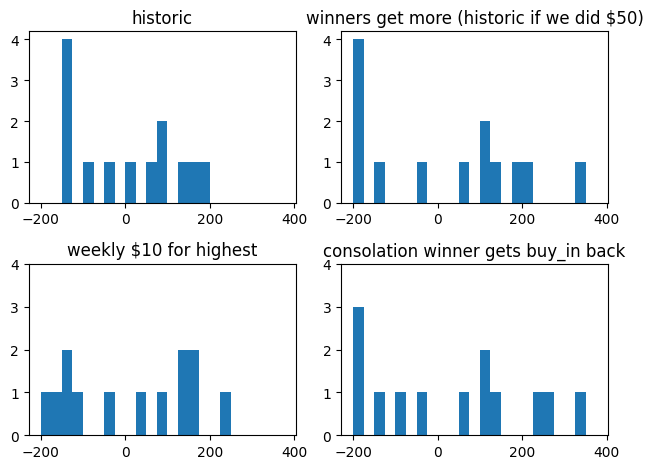

In [217]:
import matplotlib.pyplot as pyplot

fig, ((ax0, ax1), (ax2, ax3)) = pyplot.subplots(nrows=2, ncols=2)

bin = list(range(-200,400,25))

ax0.hist(final_df['hist_profit'],bin, alpha=1)
ax0.set_title('historic')

ax1.hist(final_df['scenario_1_profit'],bin, alpha=1)
ax1.set_title('winners get more (historic if we did $50)')

ax2.hist(final_df['scenario_2_profit'],bin, alpha=1)
ax2.set_title('weekly $10 for highest')

ax2.set_ylim([0,4])

ax3.hist(final_df['scenario_3_profit'],bin, alpha=1)
ax3.set_title('consolation winner gets buy_in back')

ax3.set_ylim([0,4])

fig.tight_layout()
pyplot.show()